# Preamble

## setup of environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWi9DvIpgKhoqVyyv1KE1D3gu3vleFpE-VE7oAheOkH90Fp5TbkPsws
Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Few-Shot Project/registration-vxm/source-code

/content/gdrive/My Drive/Few-Shot Project/registration-vxm/source-code


## pystrum

In [3]:
# !git clone https://github.com/adalca/pystrum

In [4]:
!pip install ./pystrum

Processing ./pystrum
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pystrum: filename=pystrum-0.2-py3-none-any.whl size=19535 sha256=6557bde89ca0b8e0fa0020191e8be323cf2e1203b46619b2954cdb8f37472c1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-vw0aoe50/wheels/8b/c2/51/e4f0cffd5826e3a191dc47efa9c4c7305c4a23d5c837cca8e2
Successfully built pystrum


## neurite

In [ ]:
# !git clone https://github.com/adalca/neurite

In [ ]:
!pip install ./neurite

## voxelmorph

In [ ]:
# !git clone https://github.com/voxelmorph/voxelmorph

In [8]:
!pip install ./voxelmorph

Processing ./voxelmorph
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for voxelmorph: filename=voxelmorph-0.1-py3-none-any.whl size=53385 sha256=bb1801f594bf1a3591ec932b13b503843667a62933287fbe29df60088550cf13
  Stored in directory: /tmp/pip-ephem-wheel-cache-6040ryni/wheels/0a/19/7c/2de4bd28875534236306f60e209a8f98ba615fea930c4cb7b7
Successfully built voxelmorph


## imports

In [ ]:
!pip install pypng -q

In [ ]:
# imports
import os, sys
import glob
import time
import png
import numpy as np
import shutil
import imageio
import pickle
import random
import torch
import matplotlib.pyplot as plt

In [11]:
# local imports
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import neurite as ne

In [25]:
device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.backends.cudnn.deterministic = True

---

# Data

In [12]:
%cd ../

/content/gdrive/My Drive/Few-Shot Project/registration-vxm


## load & normalize

In [13]:
# load
with open('./structured-data/images.pkl', 'rb') as f:
    images = pickle.load(f)
with open('./structured-data/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [14]:
print('Images:')
for p_id in images.keys():
    print(str(p_id) + ":", images.get(p_id).shape) 
print()  

print('Labels:')
for p_id in labels.keys():
    print(str(p_id) + ":", labels.get(p_id).shape) 

Images:
1: (24, 256, 256)
2: (27, 256, 256)
3: (25, 256, 256)
5: (28, 256, 256)
8: (30, 256, 256)
10: (25, 256, 256)
13: (33, 256, 256)
15: (30, 256, 256)
19: (29, 256, 256)
20: (28, 256, 256)
21: (22, 256, 256)
22: (30, 256, 256)
31: (23, 256, 256)
32: (35, 256, 256)
33: (31, 256, 256)
34: (29, 256, 256)
36: (27, 256, 256)
37: (28, 256, 256)
38: (28, 256, 256)
39: (26, 256, 256)

Labels:
1: (24, 256, 256)
2: (27, 256, 256)
3: (25, 256, 256)
5: (28, 256, 256)
8: (30, 256, 256)
10: (25, 256, 256)
13: (33, 256, 256)
15: (30, 256, 256)
19: (29, 256, 256)
20: (28, 256, 256)
21: (22, 256, 256)
22: (30, 256, 256)
31: (23, 256, 256)
32: (35, 256, 256)
33: (31, 256, 256)
34: (29, 256, 256)
36: (27, 256, 256)
37: (28, 256, 256)
38: (28, 256, 256)
39: (26, 256, 256)


In [15]:
# normalize data
for p_id in images.keys():
    max_ = images.get(p_id).max()
    images[p_id] = images.get(p_id).astype('float64')/max_

for p_id in labels.keys():
    max_ = labels.get(p_id).max()
    labels[p_id] = labels.get(p_id).astype('float64')/max_

In [16]:
# verify
print('Images:')
for p_id in images.keys():
    print(str(p_id) + ":", images.get(p_id).min(), "-", images.get(p_id).max()) 
print()

print('Labels:')
for p_id in labels.keys():
    print(str(p_id) + ":", labels.get(p_id).min(), "-", labels.get(p_id).max()) 

Images:
1: 0.0 - 1.0
2: 0.0 - 1.0
3: 0.0 - 1.0
5: 0.0 - 1.0
8: 0.0 - 1.0
10: 0.0 - 1.0
13: 0.0 - 1.0
15: 0.0 - 1.0
19: 0.0 - 1.0
20: 0.0 - 1.0
21: 0.0 - 1.0
22: 0.0 - 1.0
31: 0.0 - 1.0
32: 0.0 - 1.0
33: 0.0 - 1.0
34: 0.0 - 1.0
36: 0.0 - 1.0
37: 0.0 - 1.0
38: 0.0 - 1.0
39: 0.0 - 1.0

Labels:
1: 0.0 - 1.0
2: 0.0 - 1.0
3: 0.0 - 1.0
5: 0.0 - 1.0
8: 0.0 - 1.0
10: 0.0 - 1.0
13: 0.0 - 1.0
15: 0.0 - 1.0
19: 0.0 - 1.0
20: 0.0 - 1.0
21: 0.0 - 1.0
22: 0.0 - 1.0
31: 0.0 - 1.0
32: 0.0 - 1.0
33: 0.0 - 1.0
34: 0.0 - 1.0
36: 0.0 - 1.0
37: 0.0 - 1.0
38: 0.0 - 1.0
39: 0.0 - 1.0


## visualize

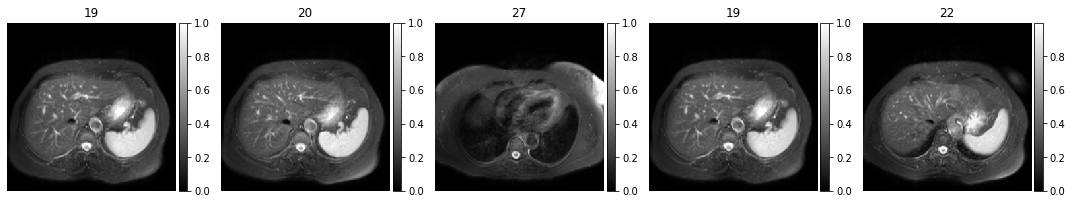

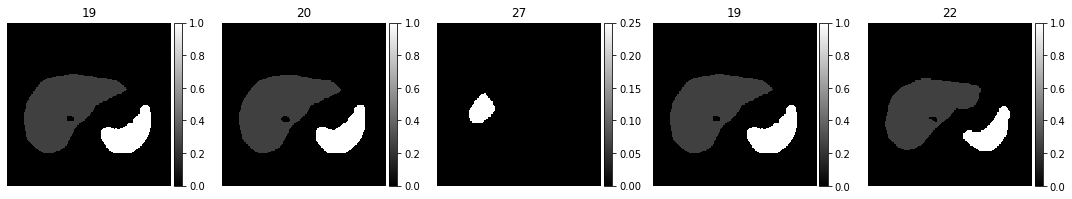

In [17]:
p_id = np.random.choice(list(images.keys()), 1)[0]
idx = np.random.randint(0, images.get(p_id).shape[0], size=5)

# visualize
img_examples = [e for e in images.get(p_id)[idx, ...]]
lb_examples = [e for e in labels.get(p_id)[idx, ...]]
ne.plot.slices(img_examples, cmaps=['gray'], do_colorbars=True, titles=idx, imshow_args=[{'origin':'lower'}]);
ne.plot.slices(lb_examples, cmaps=['gray'], do_colorbars=True, titles=idx, imshow_args=[{'origin':'lower'}]);

---

## dataloader


In [18]:
from torch.utils.data import Dataset


class BidirDataset(Dataset):
    def __init__(self, images, labels, dis):
        data = []
        for p_id, p_imgs in images.items():
            p_lbs = labels.get(p_id)
            for i in range(p_imgs.shape[0] - dis):    
                data.append((p_imgs[i], p_imgs[i + dis], p_lbs[i], p_lbs[i + dis]))
                data.append((p_imgs[i + dis], p_imgs[i], p_lbs[i + dis], p_lbs[i]))
        self.data = data
        self.vol_shape = data[0][0].shape
        self.ndims = len(self.vol_shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        outputs = [torch.tensor(d).unsqueeze(-1) for d in self.data[index]]

        return tuple(outputs)


class BidirDataset2(Dataset):
    def __init__(self, images, labels, dis):
        data = []
        for p_id, p_imgs in images.items():
            p_lbs = labels.get(p_id)
            for i in range(p_imgs.shape[0] - dis):    
                data.append((p_imgs[i], p_imgs[i + dis], p_lbs[i], p_lbs[i + dis]))
            for i in range(p_imgs.shape[0] - dis):
                data.append((p_imgs[i + dis], p_imgs[i], p_lbs[i + dis], p_lbs[i]))
        self.data = data
        self.vol_shape = data[0][0].shape
        self.ndims = len(self.vol_shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        outputs = [torch.tensor(d).unsqueeze(-1) for d in self.data[index]]
        
        return tuple(outputs)

In [19]:
from torch.utils.data import DataLoader


def get_dataloader(images, labels, batch_size, shuffle=True, pin_memory=False, workers=0):
    dataset = BidirDataset(images, labels, dis=1)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory,num_workers=workers)
    zero_phi = torch.zeros(batch_size, *dataset.vol_shape, dataset.ndims)

    return dataloader, zero_phi


In [20]:
def data_generator(patients, bs, patient_id=None, slice_ids=[]):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """
    
    if len(slice_ids) != 0:
        bs = len(slice_ids)
    
    # extract data shape and dimension
    vol_shape = list(patients.values())[0].shape[1:] 
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([bs, *vol_shape, ndims])
    
    while True:
        if patient_id is None:
            patient_id = np.random.choice(list(patients.keys()), 1)[0]
        patient = np.array(patients.get(patient_id))

        if len(slice_ids) == 0:
            slice_ids = np.random.randint(0, patient.shape[0] - 1, size=bs)
        slice_ids = np.array(slice_ids)

        moving_images = patient[slice_ids, ..., np.newaxis]
        fixed_images = patient[slice_ids + 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image)
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

# Args

In [21]:
class Args():
    def __init__(self):        
        self.lr = 0.001
        self.epochs = 150
        self.batch_size = 64
        self.smooth_weight = 0.1 
        self.seg_weight = 0.5 
        self.loss = 'mse' 
        self.load_model = None
        self.initial_epoch = 0 
        self.int_steps = 7 
        self.int_downsize = 2 
        self.model_dir = './trained-models/torch/1/'
        
args = Args()

In [22]:
os.makedirs(args.model_dir, exist_ok=False)

FileExistsError: ignored

# Run

## loss

In [ ]:
if args.loss == 'ncc':
    sim_loss_func = vxm.losses.NCC().loss
elif args.loss == 'mse':
    sim_loss_func = vxm.losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

smooth_loss_func = vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss
smooth_weight = args.smooth_weight

seg_loss_func = vxm.losses.MSE().loss
seg_weight = args.seg_weight

## dataloader

In [ ]:
dataloader, zero_phi = get_dataloader(images, labels, args.batch_size)

## model

In [ ]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

if args.load_model:
    model = vxm.networks.VxmDense.load(args.load_model, device)
else:
    model = vxm.networks.VxmDense(
        inshape=dataloader.dataset.vol_shape,
        nb_unet_features=[enc_nf, dec_nf],
        int_steps=args.int_steps,
        int_downsize=args.int_downsize
    )

model.to(device)
_ = model.train()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

## train

In [ ]:
loss_history = []

for epoch in range(args.initial_epoch, args.epochs):

    save model checkpoint
    if epoch + 1 % 50 == 0:
        model.save(os.path.join(args.model_dir, '%04d.pt' % epoch))

    epoch_loss = 0
    epoch_loss_sim = 0 
    epoch_loss_smooth = 0
    epoch_loss_seg = 0
    total_data_count = 0
    epoch_start_time = time.time()
    
    for inputs in dataloader:

        [moving_img, fixed_img, moving_lb, fixed_lb] = [d.to(device).float().permute(0, 3, 1, 2) for d in inputs]  
        zero_phi = zero_phi.to(device).float().permute(0, 3, 1, 2)
      
        bs = moving_img.shape[0]
        
        # predict
        moved_img, flow = model(moving_img, fixed_img, registration=True)
        moved_lb = model.transformer(moving_lb, flow)

        # calculate loss
        loss = 0
        sim_loss = sim_loss_func(fixed_img, moved_img)
        smooth_loss = smooth_loss_func(zero_phi, flow)
        seg_loss = seg_loss_func(fixed_lb, moved_lb)
        loss = sim_loss + (smooth_weight * smooth_loss) + (seg_weight * seg_loss)

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss * bs
        epoch_loss_sim += sim_loss * bs
        epoch_loss_smooth += smooth_loss * bs
        epoch_loss_seg += seg_loss * bs
        total_data_count += bs      

    # print epoch info
    msg = 'epoch %d/%d, ' % (epoch + 1, args.epochs)
    msg += 'loss= %.4e, ' % (epoch_loss / total_data_count)
    msg += 'sim_loss= %.4e, ' % (epoch_loss_sim / total_data_count)
    msg += 'smooth_loss= %.4e, ' % (epoch_loss_smooth / total_data_count)
    msg += 'seg_loss= %.4e, ' % (epoch_loss_seg / total_data_count)
    msg += 'time= %.4f, ' % (time.time() - epoch_start_time)
    print(msg, flush=True)

    loss_history.append(epoch_loss / total_data_count)

# final model save
model.save(os.path.join(args.model_dir, '%04d.pt' % args.epochs))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


epoch 1/150, loss= 8.9711e-03, sim_loss= 5.6728e-03, smooth_loss= 3.4217e-05, seg_loss= 6.5898e-03, time= 14.4160, 
epoch 2/150, loss= 8.8536e-03, sim_loss= 5.6372e-03, smooth_loss= 5.5743e-05, seg_loss= 6.4217e-03, time= 14.3994, 
epoch 3/150, loss= 8.6176e-03, sim_loss= 5.4367e-03, smooth_loss= 6.2965e-04, seg_loss= 6.2361e-03, time= 14.5789, 
epoch 4/150, loss= 7.7921e-03, sim_loss= 4.6996e-03, smooth_loss= 3.0007e-03, seg_loss= 5.5849e-03, time= 14.7190, 
epoch 5/150, loss= 7.3110e-03, sim_loss= 4.3465e-03, smooth_loss= 3.2338e-03, seg_loss= 5.2822e-03, time= 14.8357, 
epoch 6/150, loss= 7.0111e-03, sim_loss= 4.0633e-03, smooth_loss= 4.4679e-03, seg_loss= 5.0020e-03, time= 14.9594, 
epoch 7/150, loss= 6.9451e-03, sim_loss= 3.9983e-03, smooth_loss= 4.9426e-03, seg_loss= 4.9050e-03, time= 15.0884, 
epoch 8/150, loss= 6.8118e-03, sim_loss= 3.8726e-03, smooth_loss= 5.3672e-03, seg_loss= 4.8051e-03, time= 15.1711, 
epoch 9/150, loss= 6.7840e-03, sim_loss= 3.8462e-03, smooth_loss= 5.4716

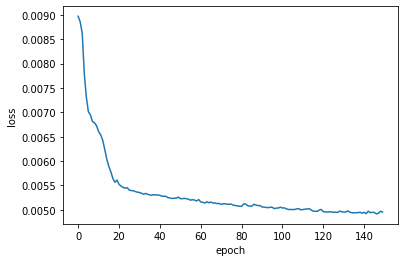

In [ ]:
plt.plot(loss_history)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Evaluate

In [41]:
load_model = './trained-models/torch/with_labels/0150.pt'
model = vxm.networks.VxmDense.load(load_model, device)
model.to(device)
model.eval();

In [27]:
val_dataloader, _ = get_dataloader(images, labels, 1)

dice_loss_func = vxm.losses.Dice().loss

In [ ]:
zero = torch.zeros(1, 1, 256, 256)
one = torch.ones(1, 1, 256, 256)

In [43]:
dice_score = []

for inputs in val_dataloader:

    [moving_img, fixed_img, moving_lb, fixed_lb] = [d.to(device).float().permute(0, 3, 1, 2) for d in inputs]  
  
    bs = moving_img.shape[0]

    with torch.no_grad():
        # predict
        moved_img, flow = model(moving_img, fixed_img, registration=True)
        moved_lb = model.transformer(moving_lb, flow)
        fixed_lb = torch.where(fixed_lb > 0, one, zero)
        moved_lb = torch.where(moved_lb > 0, one, zero)
        dice_score.append((-dice_loss_func(fixed_lb, moved_lb)).detach().cpu().numpy())

print('mean:', np.mean(dice_score), 'std:', np.std(dice_score))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


mean: 0.8887968 std: 0.101618975


# Visualize

In [ ]:
def show(patients, patient_id=None, slice_ids=[]):

    if patient_id is None:
        patient_id = np.random.choice(list(patients.keys()), 1)[0]
    patient = np.array(patients.get(patient_id))
    if len(slice_ids) == 0:
        slice_ids = np.random.randint(0, patient.shape[0] - 1, size=1)

    for i in slice_ids:
        val_generator = data_generator(patients, bs=1, patient_id=patient_id, slice_ids=[i])
        inputs, _ = next(val_generator)
        input_moving, input_fixed = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        moved, warp = model(input_moving, input_fixed, registration=True)

        input_moving = input_moving.detach().cpu().numpy().squeeze(0)
        input_fixed = input_fixed.detach().cpu().numpy().squeeze(0)
        moved = moved.detach().cpu().numpy().squeeze(0)
        warp = warp.detach().cpu().numpy().squeeze(0)

        # visualize
        images = [img[0, :, :] for img in [input_moving, input_fixed, moved, warp]] 
        titles = ['moving', 'fixed', 'moved', 'flow']
        ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


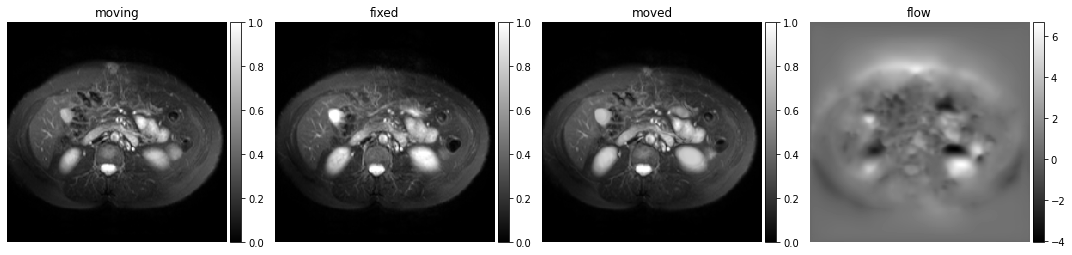

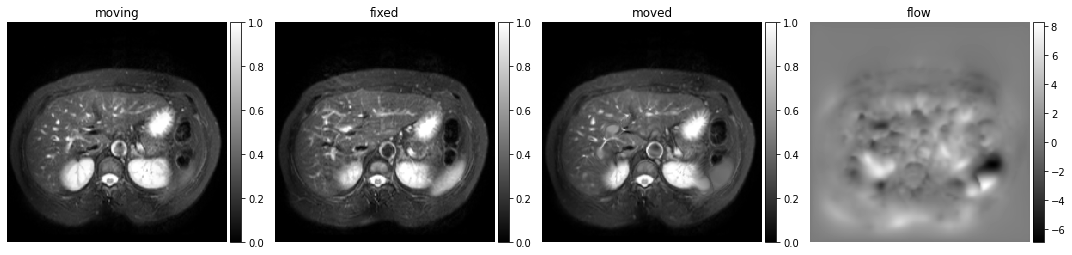

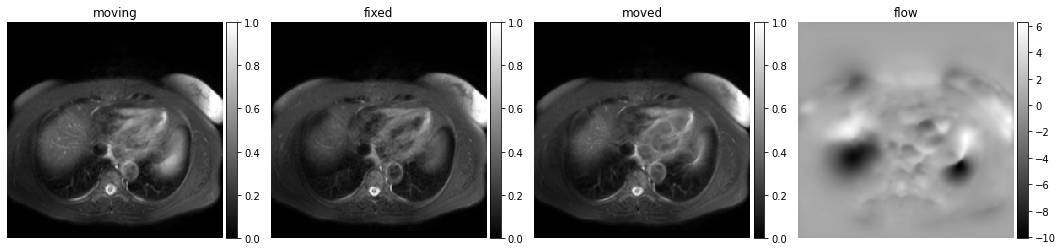

----------------------------------------------------------------------


In [ ]:
slice_ids = [5, 15, 25]
show(images, patient_id=5, slice_ids=slice_ids)